In [1]:
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/UrbanSound8K/audio/', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [5]:
df = create_dataset_df('/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/content/drive/MyDrive/UrbanSound8K/audio/fold...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8K/audio/fold...


In [6]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling',
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,air_conditioner
1,1,car_horn
2,2,children_playing
3,3,dog_bark
4,4,drilling
5,5,engine_idling
6,6,gun_shot
7,7,jackhammer
8,8,siren
9,9,street_music


In [7]:
samples = [(class_map[label], [f for f in glob.glob('/content/drive/MyDrive/UrbanSound8K/audio/fold1/*') if f.split('-')[1] == label][0])
           for label in class_map.keys()]

In [8]:
def get_sound_data(path, sr=22050):
    data, fsr = sf.read(path)
    data_22k = librosa.resample(y=data.T, orig_sr=fsr, target_sr=sr)
    if len(data_22k.shape) > 1:
        data_22k = np.average(data_22k, axis=0)
    return data_22k, sr
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]
[(sample[0], sample[1][0].shape) for sample in sample_data]

[('air_conditioner', (44982,)),
 ('car_horn', (5513,)),
 ('children_playing', (88200,)),
 ('dog_bark', (36162,)),
 ('drilling', (88200,)),
 ('engine_idling', (88200,)),
 ('gun_shot', (57551,)),
 ('jackhammer', (88200,)),
 ('siren', (88200,)),
 ('street_music', (88200,))]

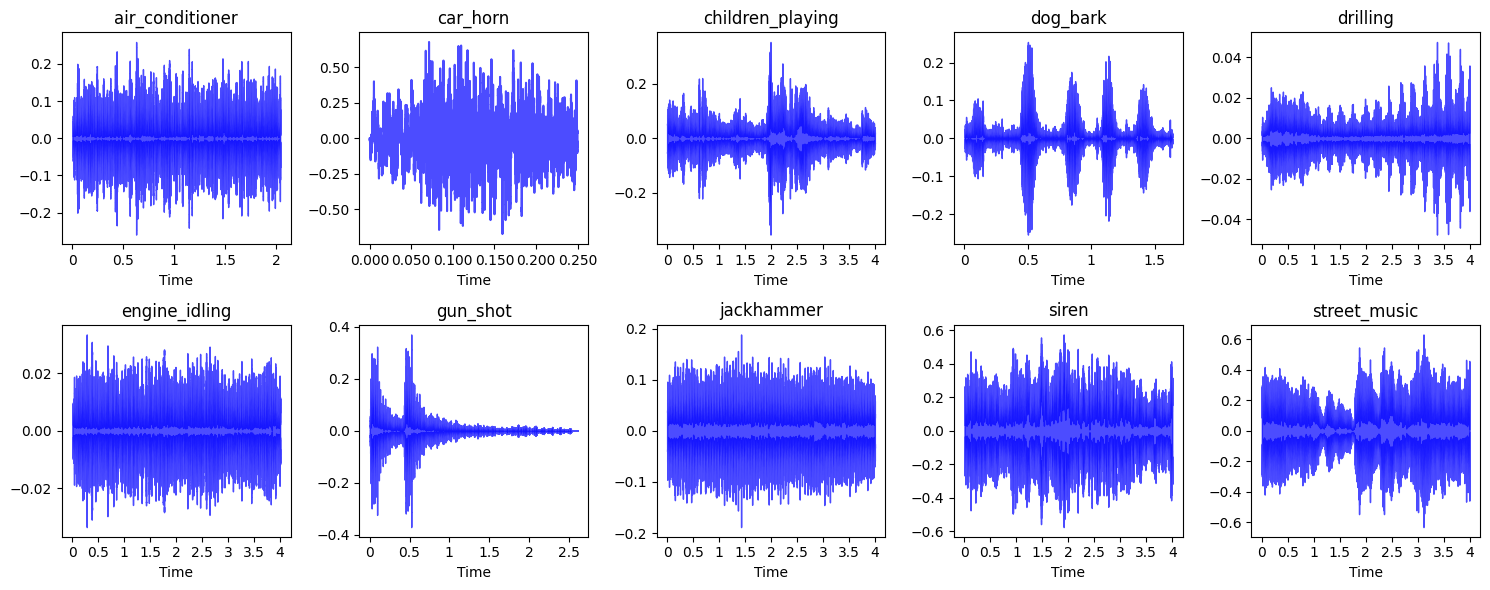

In [10]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(y=item[1][0], sr=item[1][1], color='b', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

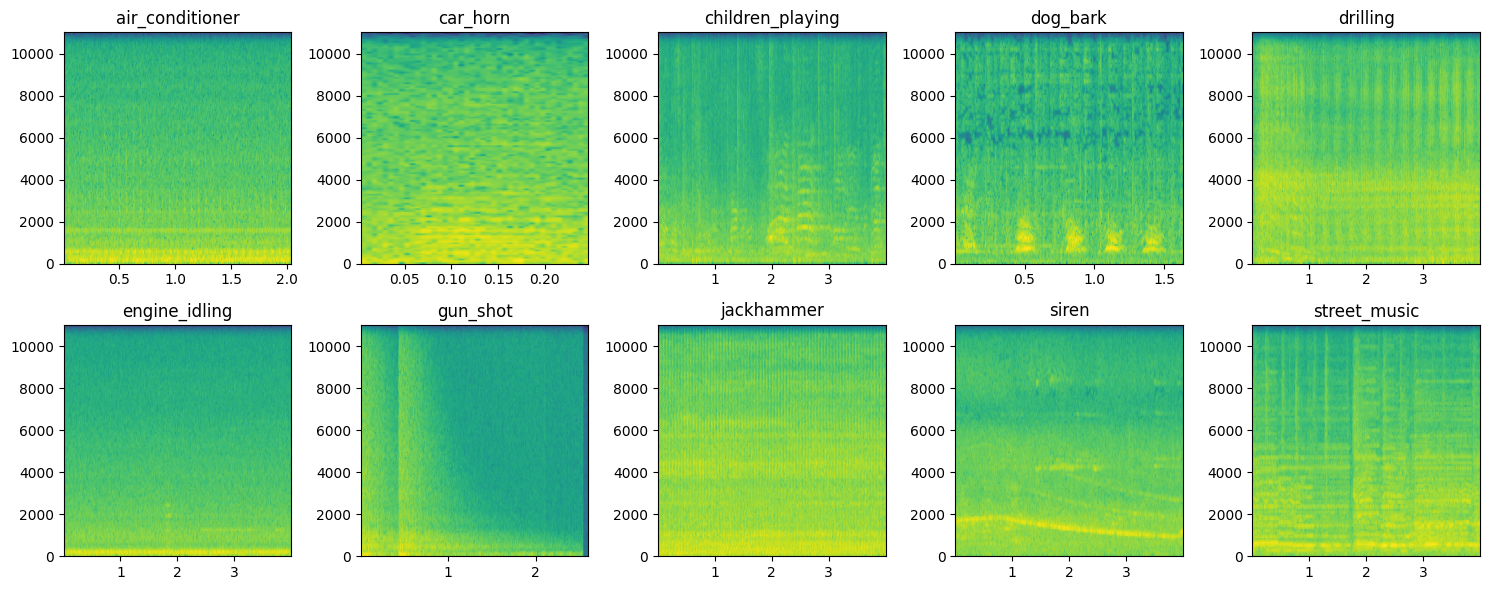

In [11]:
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

In [12]:
y,sr=librosa.load('/content/drive/MyDrive/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
mfccs.shape,melspectrogram.shape,chroma_stft.shape

((40,), (40,), (40,))

In [13]:
#stacking and reshaping
features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
features.shape

(40, 3)

In [14]:
x_train=[]
x_test=[]
y_train=[]
y_test=[]

path='/content/drive/MyDrive/UrbanSound8K/audio/fold'
for i in tqdm(range(len(df))):
    fold_no=str(df.iloc[i]["fold"])
    file=df.iloc[i]["slice_file_name"]
    label=df.iloc[i]["classID"]
    filename=path+fold_no+"/"+file
    y,sr=librosa.load(filename)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
    chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft)),(40,3))
    if(fold_no!='10'):
      x_train.append(features)
      y_train.append(label)
    else:
      x_test.append(features)
      y_test.append(label)

  1%|          | 66/8732 [00:47<1:02:58,  2.29it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
 41%|████      | 3555/8732 [42:39<1:05:24,  1.32it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8325/8732 [1:40:02<03:54,  1.74it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
 95%|█████████▌| 8329/8732 [1:40:03<01:39,  4.03it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [1:44:52<00:00,  1.39it/s]


In [15]:
x=x_train+x_test
y=y_train+y_test

In [16]:
x=np.array(x)
y=np.array(y)
x.shape,y.shape

((8732, 40, 3), (8732,))

In [17]:
#reshaping into 2d to save in csv format
x_2d=np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]))
x_2d.shape
#saving the data numpy arrays
np.savetxt("x.csv", x_2d, delimiter=",")
np.savetxt("y.csv",y,delimiter=",")

In [18]:
x_2d.shape

(8732, 120)

In [19]:
import math

In [20]:
indexes = []
total = len(df)
indexes = list(range(0, total))
# Randomize indexes random.shuffle(indexes)
# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)
# Split the data
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
# Split the features with the same indexes
X_test = np.take(x, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(x, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
# Also split metadata
test = df.iloc[test_split_idx]
train = df.iloc[train_split_idx]
# Print status
print("Test split: {} \t\t Train split: {}".format(len(test), len(train)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 3) 	 X train shape: (6986, 40, 3)
y test shape: (1746,) 		 y train shape: (6986,)


In [21]:
#converting to one hot
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_train.shape,y_test.shape

((6986, 10), (1746, 10))

In [22]:
#reshaping to 2D
X_train=np.reshape(X_train,(X_train.shape[0], 40,3))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3))
X_train.shape,X_test.shape

((6986, 40, 3), (1746, 40, 3))

In [23]:
#reshaping to shape required by CNN
X_train=np.reshape(X_train,(X_train.shape[0], 40,3,1))
X_test=np.reshape(X_test,(X_test.shape[0], 40,3,1))
X_train.shape,X_test.shape

((6986, 40, 3, 1), (1746, 40, 3, 1))

In [24]:
model=Sequential()
#adding layers and forming the model
model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="elu",input_shape=(40,3,1)))
model.add(MaxPooling2D(padding="same"))
model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="elu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(512,activation="elu"))
model.add(Dropout(0.3))
model.add(Dense(10,activation="softmax"))

In [25]:
#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#training the model
model.fit(X_train,y_train,batch_size=50,epochs=30,validation_data=(X_test,y_test))

Epoch 1/30
140/140 [==============================] - 20s 128ms/step - loss: 1.7563 - accuracy: 0.4343 - val_loss: 1.8742 - val_accuracy: 0.3837
Epoch 2/30
140/140 [==============================] - 19s 134ms/step - loss: 1.1332 - accuracy: 0.6185 - val_loss: 2.0036 - val_accuracy: 0.3414
Epoch 3/30
140/140 [==============================] - 17s 123ms/step - loss: 0.8779 - accuracy: 0.7001 - val_loss: 2.1735 - val_accuracy: 0.3751
Epoch 4/30
140/140 [==============================] - 17s 122ms/step - loss: 0.7182 - accuracy: 0.7642 - val_loss: 2.2071 - val_accuracy: 0.4061
Epoch 5/30
140/140 [==============================] - 17s 122ms/step - loss: 0.6167 - accuracy: 0.7902 - val_loss: 2.7353 - val_accuracy: 0.3883
Epoch 6/30
140/140 [==============================] - 17s 122ms/step - loss: 0.5572 - accuracy: 0.8151 - val_loss: 2.7276 - val_accuracy: 0.4078
Epoch 7/30
140/140 [==============================] - 16s 118ms/step - loss: 0.4793 - accuracy: 0.8438 - val_loss: 2.8379 - val_ac

In [26]:
#train and test loss and scores respectively
train_loss_score=model.evaluate(X_train,y_train)
test_loss_score=model.evaluate(X_test,y_test)
print(train_loss_score)
print(test_loss_score)

55/55 [==============================] - 1s 16ms/step - loss: 4.0854 - accuracy: 0.4599
[0.04866253584623337, 0.981534481048584]
[4.085439205169678, 0.4599083662033081]


In [27]:
# Predict probabilities for test set
y_probs = model.predict(X_test)
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test, axis=1)
# Add "pred" column
test['pred'] = yhat_probs

55/55 [==============================] - 1s 16ms/step


<ipython-input-27-1235db5f3c9d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = yhat_probs


In [28]:
np.set_printoptions(precision=2)
# Compute confusion matrix data
cm = metrics.confusion_matrix(y_trues, yhat_probs)
print(cm)

[[  8   0   3   0   0   0  16  64   0  98]
 [  0  28   0   0   0   0   0   0   0   9]
 [  2   0 100  11   2   0  14   1   2  13]
 [  0   0  16 127   8   0   7   0   9   5]
 [  0   0   0  13 110   1   1   6   6  33]
 [ 31  24  32  10  11  91   6  75   4  25]
 [  1   4   0   1   2  30  69   0   0  13]
 [  8  10   0   0 155   2   0  23   0  21]
 [ 15   2  11  39   4   4   0   2  95  24]
 [  4   1  12   7   1   1   1   2   8 152]]


In [29]:
# Define a labels array for future use
labels = [ 'Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music' ]
# Build classification report
re = metrics.classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.12      0.04      0.06       189
        Car Horn       0.41      0.76      0.53        37
Children Playing       0.57      0.69      0.63       145
        Dog bark       0.61      0.74      0.67       172
        Drilling       0.38      0.65      0.48       170
   Engine Idling       0.71      0.29      0.42       309
        Gun Shot       0.61      0.57      0.59       120
      Jackhammer       0.13      0.11      0.12       219
           Siren       0.77      0.48      0.59       196
    Street Music       0.39      0.80      0.52       189

        accuracy                           0.46      1746
       macro avg       0.47      0.51      0.46      1746
    weighted avg       0.48      0.46      0.43      1746



In [30]:
# Set your path to the dataset
audio_path = os.path.abspath('/content/UrbanSound8K/audio')

In [31]:
# Find the target misclassified ocurrencies
dog_as_children = test[(test['classID'] == 3) & (test['pred'] == 2)]
files = []
for idx, row in dog_as_children.iterrows(): fold_num = str(row['fold'])
file_name = row['slice_file_name']
category = row['class']
file_path = audio_path + '/fold'+ fold_num +'/' + file_name
files.append(file_path)
print("Dog Barks as Children Playing: {} ocurrencies".format(len(dog_as_children)))
# Manully set the file index
index = 24
# Display results
print("\nTrue category: {}".format(category))

Dog Barks as Children Playing: 14 ocurrencies

True category: dog_bark
